In [1]:
#importing libraries

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns






In [3]:
# loading dataset
data_dir = "bike_images"
img_size = (224, 224)
batch_size = 16

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 33 files belonging to 2 classes.
Using 27 files for training.
Found 33 files belonging to 2 classes.
Using 6 files for validation.
Classes: ['city', 'race']


In [4]:
#prefetch and buildin models
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
#Train
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.6073 - loss: 0.7773 - val_accuracy: 0.5000 - val_loss: 0.5920
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8349 - loss: 0.3424 - val_accuracy: 0.8333 - val_loss: 0.4484
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9012 - loss: 0.2992 - val_accuracy: 0.8333 - val_loss: 0.2510
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 751ms/step - accuracy: 0.9545 - loss: 0.1738 - val_accuracy: 0.6667 - val_loss: 0.3911
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8843 - loss: 0.2070 - val_accuracy: 0.6667 - val_loss: 0.3610


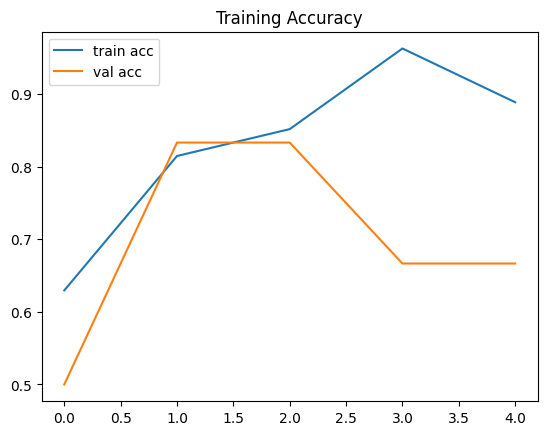

In [6]:

#plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training Accuracy")
plt.show()


In [16]:

#testing phase

def predict_images_from_labeled_folders(base_folder):
    y_true = []
    y_pred = []
    filenames = []

    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(label_path, filename)
                img = tf.keras.utils.load_img(img_path, target_size=img_size)
                img_array = tf.keras.utils.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0)
                predictions = model.predict(img_array, verbose=0)
                predicted_class = class_names[np.argmax(predictions[0])]
                confidence = np.max(predictions[0])

                print(f"{filename} → Prediction: {predicted_class} ({confidence:.2f}) | Actual: {label_folder}")

                y_pred.append(np.argmax(predictions[0]))
                y_true.append(class_names.index(label_folder))
                filenames.append(filename)


    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


Look_795_30th_Anniversary_Dura-Ace_9100-Mavic_Custom_Build_(30636542393).jpg → Prediction: city (0.55) | Actual: race
images (1).jpg → Prediction: city (0.75) | Actual: race
images (4).jpg → Prediction: city (0.80) | Actual: race
images (5).jpg → Prediction: city (0.81) | Actual: race
New-Ares-Pearl-white-dura-ace-bike.jpg → Prediction: race (1.00) | Actual: race
model_SuperSixEVO_C23.jpg → Prediction: race (0.95) | Actual: race
New-Ares-Candy-Red-105-Bike.jpg → Prediction: race (0.98) | Actual: race
2025_Pride_Pearl-White.png → Prediction: race (0.94) | Actual: race
frpVCjUG6cxzxCXF2W89GL.jpg → Prediction: race (0.86) | Actual: race
J5o8JN9iHNdKcs2HoXTEN3.jpg → Prediction: race (0.91) | Actual: race
Stiffness-to-weight_image_1024x.png → Prediction: race (1.00) | Actual: race
model_SystemSix_C23.jpg → Prediction: race (0.96) | Actual: race
images (2).jpg → Prediction: city (0.50) | Actual: race
122216_orro_venturi_tri_ultegra_di2_airbeat_tt_bike_2023.jpg → Prediction: race (0.92) | Act

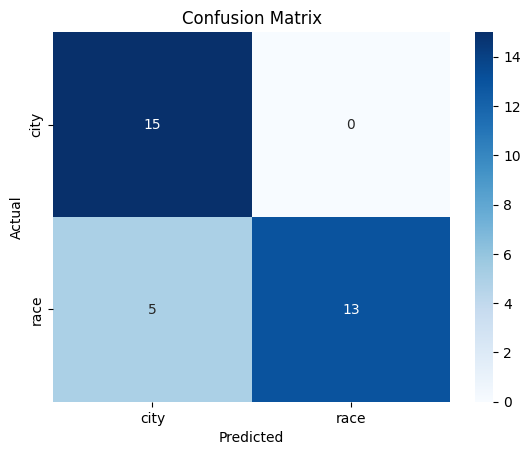


Classification Report:
              precision    recall  f1-score   support

        city       0.75      1.00      0.86        15
        race       1.00      0.72      0.84        18

    accuracy                           0.85        33
   macro avg       0.88      0.86      0.85        33
weighted avg       0.89      0.85      0.85        33



In [17]:
predict_images_from_labeled_folders("/content/test")
